# RAPID-DASH Nanopore sequencing analysis notebook

In [1]:
# Importing the packages
import matplotlib.pyplot as plt
import seaborn as sns
import edlib
import pickle
from collections import Counter
# for gRNA matching
from rapidfuzz import process 
from rapidfuzz.distance.Levenshtein import distance as lev

In [2]:
#Loading all the custom functions

#function to get the alignment positions of the insert within the array --> used to map each gRNA cassette within the array
def get_align_pos(seq, kmer, dist):
    '''Return the start and end index of the best alignment of kmer in seq.
        Parameters:
            seq (str): A sequence to search in.
            kmer (str): A sequence to search for.
            dist (int): Maximum distance for alignment.
        Returns:
            ((int, int)): Start and end indices of the first best alignment of
            kmer in seq, or -1 if no alignment found.
    '''
    result = edlib.align(kmer, seq, mode="HW", task="locations", k=dist)
    # print(result)
    return result["locations"] if result["locations"] else -1

#function to get uptstream region from the alignment position obtained above --> used to extract the gRNA sequence
def get_upstream_region(seq, kmer, dist, upstream_len=30):
    '''Return the upstream region of cerain length from kmer .
        Parameters:
            seq (str): A sequence to search in.
            kmer (str): A sequence to search for.
            dist (int): Maximum distance for alignment.
            upstream_len (int): Length of the upstream region to extract.
        Returns:
            [str]: extracted upstream sequence of kmer
    '''
    result = get_align_pos(seq, kmer, dist)
    gRNAs = []
    if result != -1:
        for unit in result:
            # Get the start index of the first alignment
            start = unit[0]
            
            # Calculate the upstream region
            upstream_start = max(0, start - upstream_len)
            upstream_end = start
            gRNAs.append(seq[upstream_start:upstream_end])
        return gRNAs
    else:
        return []
    
#function to extract all the kmer sequences from the array --> used to map gRNA sequences with  rapid fuzz
def all_kmers(seq, k):
    '''Return all kmers of length k in seq.
    Parameters:
        seq (str): A sequence to search in.
        k (int): Length of the kmer.
    Returns:
        [str]: List of all kmers.
    '''

    return [seq[i:i + k] for i in range(len(seq) - k + 1)]

#function to get the best alignment of the gRNA sequence within the array using rapid fuzz
def kmer_matches(seq, kmer, dist, max_len = 5, limit = 100):
    '''Return the all gRNA cassettes within the array.
        Parameters:
            seq (str): A sequence to search in.
            kmer (str): A sequence to search for.
            dist (int): Maximum distance for alignment.
            max_len (int): Distance to match the kmer overlaps
            limit (int): Maximum number of matches to return
        Returns:
            [(str, int, int)]: Mapped kmer, Alignment score and Alignment position within the array .
    '''

    # Get all kmers of the same length as the kmer to be matched
    seqs = all_kmers(seq, len(kmer))
    
    # Use rapidfuzz to get the best alignment of the kmer in the sequence
    kmer_matches = process.extract(kmer, seqs, scorer=lev, limit=limit, score_cutoff=dist)
    
    # Sort the matches by score
    data_sorted = sorted(kmer_matches, key=lambda x: x[2])
    
    filtered_data_by_score = []

    for entry in data_sorted:
        # Get the sequence, score, and index of the match
        seq, score, index = entry

        # Check if the index is within `max_len` of an existing entry in filtered_data_by_score
        overlapping_entries = [
            existing for existing in filtered_data_by_score if abs(index - existing[2]) <= max_len
        ]

        if overlapping_entries:
            # If overlapping entries exist, only keep the one with the lowest score
            min_score_entry = min(overlapping_entries + [entry], key=lambda x: x[1])
            # Replace the overlapping entry with the new one if it's better
            filtered_data_by_score = [
                e for e in filtered_data_by_score if abs(index - e[2]) > max_len
            ]
            filtered_data_by_score.append(min_score_entry)
        else:
            filtered_data_by_score.append(entry)
    
    # Return the filtered list of matches
    return filtered_data_by_score

#function to extract the downstream region from the alignment position obtained above --> used to extract the gRNA sequence
def get_gRNA_seq(seq, ind, kmer_len, length = 30):
    '''Return downstream sequences of certain length within the array.
        Parameters:
            seq (str): A sequence to serach in.
            ind (int): index in the seq to search.
            kmer_len (int): length of the kmer used to extract the gRNA units
            length (int): length of the downstream sequence to extract
        Returns:
            (str): extracted downstream sequences from seq
    '''
    i = ind+kmer_len #map the start of downstream region to extract the gRNA sequence
    gRNA = seq[i:i+length]
    return gRNA

In [3]:
#Loading .pkl files containing the array sequences
data_dir = "../data/nanopore_sequencing/bulk_plasmid_sequencing/"
all_sequences = []
for i in range(1, 4):
    with open(f"{data_dir}assembly{i}_inserts.pkl", 'rb') as f:
        data = pickle.load(f)
        inserts = []
        for record in data:
            s = record[1][0]
            if s:
                inserts.append(s)
    all_sequences.append(inserts)

# remove empty sequences from sublists
sequences = []
for sublist in all_sequences:
    non_empty_sublist = [item for item in sublist if item]
    sequences.append(non_empty_sublist)

In [4]:
for i, x in enumerate(sequences):
    print(f"{len(x)} sequences in assembly {i+1}")

66 sequences in assembly 1
171 sequences in assembly 2
190 sequences in assembly 3


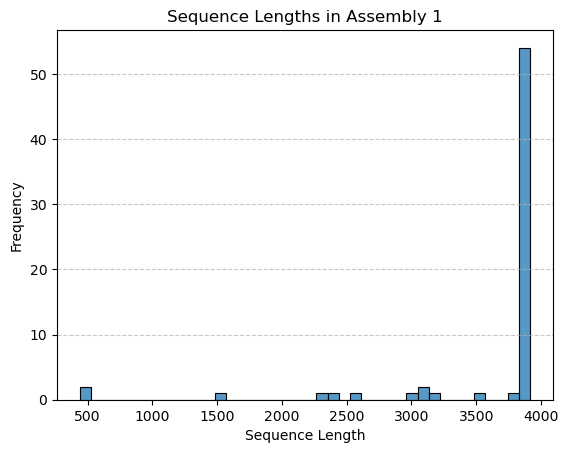

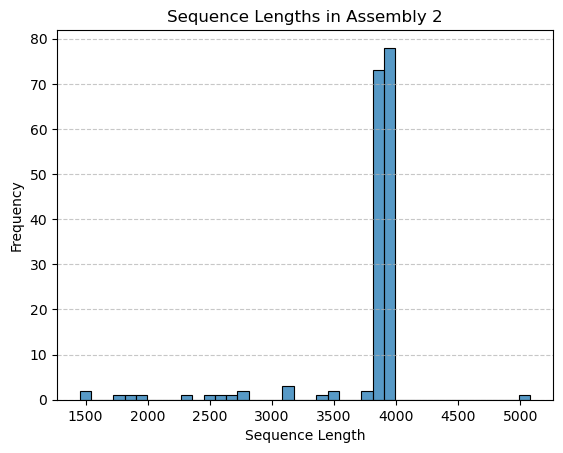

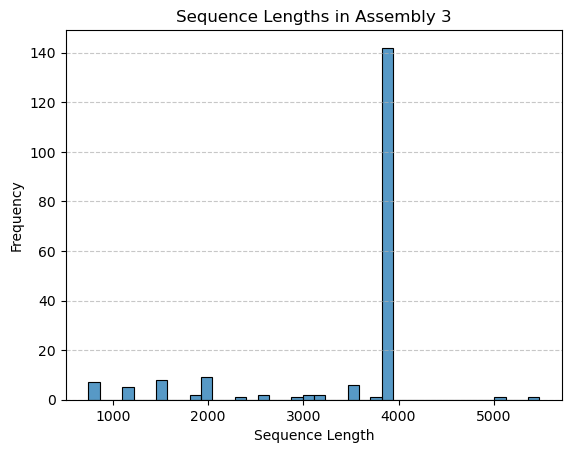

In [5]:
def plot_seq_len(seqs, i):
    seq_len = [len(seq) for seq in seqs]
    # Create the histogram using seaborn
    sns.histplot(seq_len, bins=40, kde=False, edgecolor='black')
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    #plt.xlim(0, 8500)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"Sequence Lengths in Assembly {i}")
    # Show the plot
    plt.show()

for i, x in enumerate(sequences):
    plot_seq_len(x, i+1)

In [6]:
KMER = "tcgatttcttggctttatatatcttGTGGAAAGGACGAAACACCg".upper() #sequence preceding the gRNA spacers to search in the array

def get_gRNAunit_list(seqs, kmer):
    gRNAunit_list = []
    for seq in seqs:
        gRNAunit_list.append(kmer_matches(seq, kmer, 12, max_len =15, limit= 200)) #Returns all the possible matches of the scaffold sequence in the gRNAunit_list

    return gRNAunit_list

def get_n_units(gRNAunit_list):
    #Counting how many gRNA cassettes are present in the arrays
    no_of_units = []
    for i, record in enumerate(gRNAunit_list):
        # print(i)
        no_of_units.append(len(record))
        
    return Counter(no_of_units) #Counting the number of gRNA cassettes in the arrays

gRNAunit_lists = []
for i, x in enumerate(sequences):
    gRNAunit_list = get_gRNAunit_list(x, KMER)
    gRNAunit_lists.append(gRNAunit_list)
    print(get_n_units(gRNAunit_list))

Counter({10: 45, 9: 9, 8: 5, 0: 3, 4: 1, 6: 1, 7: 1, 5: 1})
Counter({10: 141, 9: 12, 8: 5, 7: 4, 0: 2, 5: 2, 4: 2, 3: 1, 6: 1, 13: 1})
Counter({10: 131, 9: 16, 5: 11, 4: 8, 3: 5, 2: 5, 8: 4, 7: 3, 1: 2, 0: 2, 14: 1, 6: 1, 13: 1})


In [7]:
#Extracting all the gRNA cassettes from a given array sequence
def get_gRNAunits_set(seqs, gRNAunit_list):
    gRNAunits_set = []
    kmer_len = len(KMER) #length of the scaffold sequence
    for i, seq in enumerate(seqs):
        gRNAunits = []
        for unit in gRNAunit_list[i]:
            gRNA = get_gRNA_seq(seq, unit[2], kmer_len, length = 20) #Extracting the downstream sequence from the alignment position
            gRNAunits.append(gRNA)
        gRNAunits_set.append(gRNAunits)
    return gRNAunits_set

gRNAunits_sets = []
for i, x in enumerate(sequences):
    gRNAunits_set = get_gRNAunits_set(x, gRNAunit_lists[i])
    gRNAunits_sets.append(gRNAunits_set)

In [8]:
gRNA_list = ["GGAATCCCTTCTGCAGCACC", "GAGTCCGAGCAGAAGAAGAA", "TTTATCACAGGCTCCAGGAA", "GGCCCAGACTGAGCACGTGA", 
             "ACTCACGCTGGATAGCCTCC", "GTCATCTTAGTCATTACCTG", "GGCACTGCGGCTGGAGGTGG", "CACCTACCTAAGAACCATCC", 
             "TTCGTATCTGTAAAACCAAG", "CACGGTCACCCTGACACGCT"]

def get_gRNA_map(gRNAunits_set, gRNA_list):
    gRNA_map =[]
    for ind, set in enumerate(gRNAunits_set):
        if len(set) == 10:
            unit_map = []
            for sample in set:
                matched = False
                for j, gRNA in enumerate(gRNA_list):
                    aligned = edlib.align(gRNA, sample, mode="HW", task="locations", k=4)
                    if aligned["locations"]:
                        unit_map.append(j+1)  # Append the index of the matching gRNA
                        matched = True
                        break
                if not matched:
                    unit_map.append(0)
            gRNA_map.append(unit_map)
    return gRNA_map

gRNA_maps = []
for i, x in enumerate(gRNAunits_sets):
    gRNA_map = get_gRNA_map(x, gRNA_list)
    gRNA_maps.append(gRNA_map)

In [9]:
for i, gRNA_map in enumerate(gRNA_maps):
    print(f"Assembly {i+1}:")
    # Convert sublists to tuples for comparison
    sublists_as_tuples = list([tuple(row) for row in gRNA_map])

    # Find duplicates by comparing the length of the set and the original list
    #has_duplicates = len(sublists_as_tuples) != len(set(sublists_as_tuples))

    # Count occurrences of each sublist
    sublist_counts = Counter(sublists_as_tuples)

    # Extract repeated sublists
    repeated_sublists = [sublist for sublist, count in sublist_counts.items() if count > 1]

    if len(repeated_sublists) != 0:
        print(f"The main list contains repeated sublists:")
        for sublist in repeated_sublists:
            print(f"Repeated sublist: {list(sublist)}, Count: {sublist_counts[sublist]}")
    else:
        print("No repeated sublists found in the main list.")

Assembly 1:
The main list contains repeated sublists:
Repeated sublist: [1, 2, 3, 4, 5, 10, 7, 8, 9, 0], Count: 41
Assembly 2:
The main list contains repeated sublists:
Repeated sublist: [1, 2, 3, 0, 5, 6, 10, 8, 9, 0], Count: 5
Repeated sublist: [1, 2, 3, 4, 5, 6, 10, 8, 9, 0], Count: 105
Repeated sublist: [1, 2, 3, 4, 5, 6, 0, 8, 9, 0], Count: 4
Repeated sublist: [1, 2, 0, 4, 5, 6, 10, 8, 9, 0], Count: 2
Repeated sublist: [1, 2, 3, 4, 5, 6, 10, 0, 9, 0], Count: 2
Repeated sublist: [1, 0, 3, 4, 5, 6, 10, 8, 9, 0], Count: 3
Repeated sublist: [0, 2, 3, 4, 5, 6, 10, 8, 9, 0], Count: 4
Repeated sublist: [1, 2, 3, 4, 5, 0, 10, 8, 9, 0], Count: 2
Repeated sublist: [1, 2, 3, 4, 5, 6, 10, 8, 0, 0], Count: 2
Assembly 3:
The main list contains repeated sublists:
Repeated sublist: [1, 2, 3, 4, 5, 0, 7, 8, 9, 10], Count: 3
Repeated sublist: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Count: 99
Repeated sublist: [1, 2, 3, 4, 5, 6, 0, 8, 9, 10], Count: 2
Repeated sublist: [1, 0, 3, 4, 5, 6, 7, 8, 9, 10], Coun

# Calculating the percentage of correct assemblies from nanopore reads

This can be estimated by calulating the number of reads of length that matches with 10 gRNA arrays over all the reads obtained from bulk plasmid sequencing. This can be tricky because of the indel errors in nanopore reads. A solution is use of range of read length for each gRNA array category (1 to 10). The followings equences were used in get_plasmid_inserts to extract the gRNA array sequence:

UPSTREAM: **gcgttaacgctagcatggatgttttcccagtcacgacgttgtaaaacgacggccagtcttaagcgtctcatggcctgaccccggaccaagtggtggggta** 

DOWNSTREAM: **tggtcatagctgtttcctcgtagcaagcaagcgctcgaaacggtgcagcggctgttgccggtgctgtgccaggaccatggcctgaccccggaccaagtgg**

The length of the sequence between these flanks for arrays of differen gRNA assemblies is as follows:

| Number of gRNAs | Expected length | Lower range | Upper range |
|-----------------|-----------------|-------------|-------------|
| 10              | 3917            | 3847        | 3987        |
| 9               | 3523            | 3453        | 3593        |
| 8               | 3129            | 3059        | 3199        |
| 7               | 2735            | 2665        | 2805        |
| 6               | 2341            | 2271        | 2411        |
| 5               | 1947            | 1877        | 2017        |
| 4               | 1553            | 1483        | 1623        |
| 3               | 1159            | 1089        | 1229        |
| 2               | 765             | 695         | 835         |
| 1               | 371             | 301         | 441         |
| 0               | 0               | -           | 70          |
| >10             | >4311           | 4241        | -           |


Using ±70 bp to account for nanopore errors while calculating the number of gRNA units within the arrays. 70 bp was chosen because one individual gRNA unit is 371 bp and the buffering sequence length cannot exceed this and it looks like majority of the gRNA array lengths fall within these ranges.

In [10]:
# get length of each sequence in each list in sequences
seq_lens = []
for x in all_sequences:
    seq_len = [len(seq) for seq in x]
    seq_lens.append(seq_len)

In [11]:
def categorize_sequences(seq_lengths):
    """
    Takes a list of sequence lengths (integers) and returns a dictionary
    counting how many sequences fall into each gRNA bin, based on the 
    lower/upper ranges you provided.
    """

    # Define the bins: (gRNA_label, lower_bound, upper_bound).
    # Use None if there is no bound on that side (but we have exact ranges from your table).
    bins = [
        (0, 0, 70),
        (1, 301, 441),
        (2, 695, 835),
        (3, 1089, 1229),
        (4, 1483, 1623),
        (5, 1877, 2017),
        (6, 2271, 2411),
        (7, 2665, 2805),
        (8, 3059, 3199),
        (9, 3453, 3593),
        (10, 3847, 3987),
        ('>10', 4241, float('inf'))  # For sequence lengths >= 4050
    ]

    # Initialize a dictionary to count occurrences in each bin
    bin_counts = {b[0]: 0 for b in bins}
    bin_counts.setdefault('out_of_range', 0)
    out_of_range = []

    for i, length in enumerate(seq_lengths):
        # Check each bin to see where this length falls
        placed = False
        for gRNA_label, low, high in bins:
            if low <= length <= high:
                bin_counts[gRNA_label] += 1
                placed = True
                break
        
        if not placed:
            bin_counts['out_of_range'] += 1
            out_of_range.append(i)

    return bin_counts, out_of_range



In [12]:
for i, x in enumerate(seq_lens):
    print(f"{len(x)} sequences in assembly {i+1}")

66 sequences in assembly 1
171 sequences in assembly 2
190 sequences in assembly 3


In [13]:
unit_counts = []
for i, x in enumerate(seq_lens):
    counts = categorize_sequences(x)[0]
    unit_counts.append(counts)
    print(f"Assembly {i+1}:")
    print(counts)

Assembly 1:
{0: 0, 1: 2, 2: 0, 3: 0, 4: 1, 5: 0, 6: 2, 7: 0, 8: 3, 9: 1, 10: 54, '>10': 0, 'out_of_range': 3}
Assembly 2:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 3, 8: 3, 9: 2, 10: 150, '>10': 1, 'out_of_range': 9}
Assembly 3:
{0: 0, 1: 0, 2: 7, 3: 5, 4: 8, 5: 11, 6: 1, 7: 0, 8: 3, 9: 6, 10: 141, '>10': 2, 'out_of_range': 6}


In [14]:
percentages = []
for i, counts in enumerate(unit_counts):
    print(f"Assembly {i+1}:")
    total_sequences = sum(counts.values())
    count_10 = counts[10]
    percentage_10 = (count_10 / total_sequences) * 100 if total_sequences > 0 else 0
    percentages.append(percentage_10)

    print("Bin counts:", counts)
    print(f"Total sequences: {total_sequences}")
    print(f"Count in bin 10: {count_10}")
    print(f"Percentage in bin 10: {percentage_10:.2f}%")

Assembly 1:
Bin counts: {0: 0, 1: 2, 2: 0, 3: 0, 4: 1, 5: 0, 6: 2, 7: 0, 8: 3, 9: 1, 10: 54, '>10': 0, 'out_of_range': 3}
Total sequences: 66
Count in bin 10: 54
Percentage in bin 10: 81.82%
Assembly 2:
Bin counts: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 3, 8: 3, 9: 2, 10: 150, '>10': 1, 'out_of_range': 9}
Total sequences: 171
Count in bin 10: 150
Percentage in bin 10: 87.72%
Assembly 3:
Bin counts: {0: 0, 1: 0, 2: 7, 3: 5, 4: 8, 5: 11, 6: 1, 7: 0, 8: 3, 9: 6, 10: 141, '>10': 2, 'out_of_range': 6}
Total sequences: 190
Count in bin 10: 141
Percentage in bin 10: 74.21%


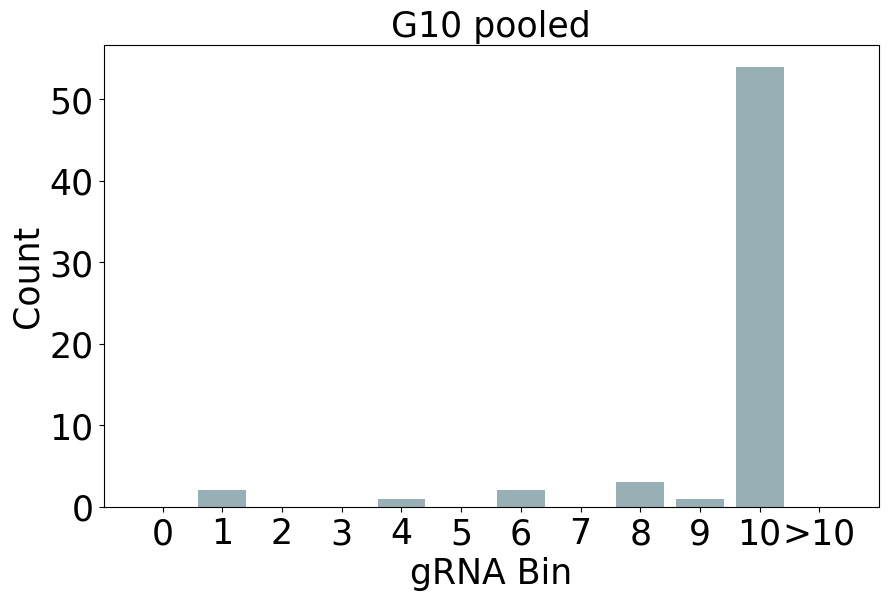

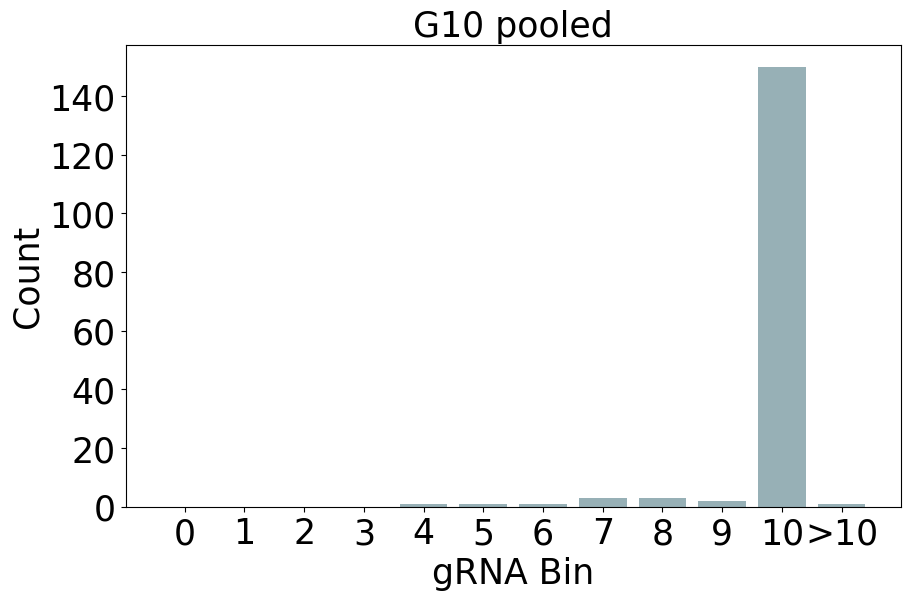

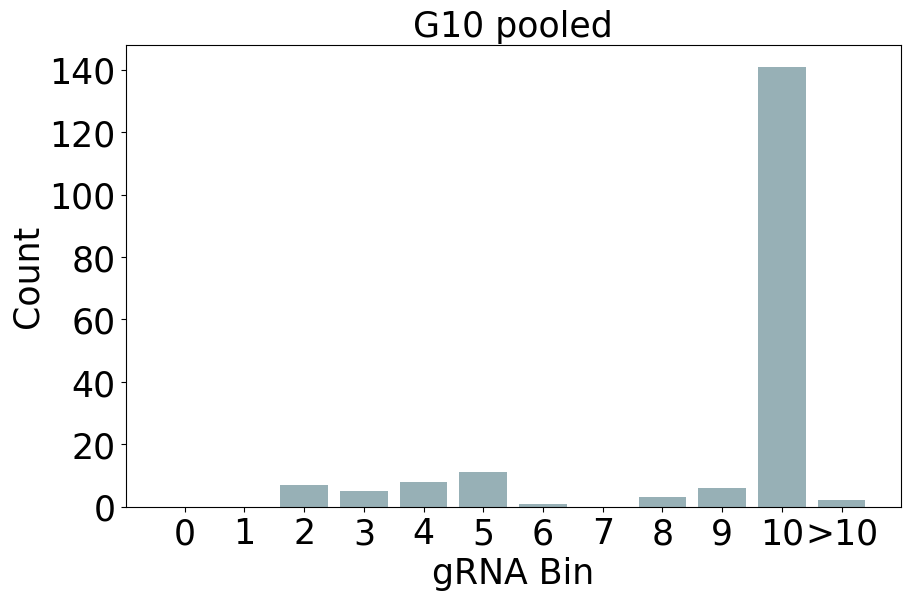

In [15]:
for i, counts in enumerate(unit_counts):
    bin_labels = [str(k) for k in counts.keys() if k != 'unassigned']
    bin_values = [counts[k] for k in counts.keys() if k != 'unassigned']

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_labels[0:12], bin_values[0:12], color='#97B0B6')
    plt.xlabel('gRNA Bin', fontsize=25)
    plt.ylabel('Count', fontsize=25)
    plt.title('G10 pooled', fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    # if i == 0:
    #     plt.savefig("G10_pooled.svg", transparent=True)
    plt.show()


In [16]:
#Average percentage of sequences with 10 gRNA cassettes in the array
average_percentage = sum(percentages)/len(percentages)  
average_percentage

81.24933545986177